<a href="https://colab.research.google.com/github/Joovvhan/ColabTest/blob/master/notebooks/eumun_to_eumjul_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import copy
import matplotlib.pyplot as plt
import random

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [22]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/eumjul_eumun_pairs.npy'

pairs = np.load(data_path)

In [24]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
# unicode_jamo_list += [' ', '!', ',', '.', '?', '<eos>']
    
unicode_jamo_list.sort()

# unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

tokenized_pair = [[tokenizer.word2num(list(pairs[i, 0]) + ['<eos>']), tokenizer.word2num(list(pairs[i, 1]) + ['<eos>'])] for i in range(len(pairs))]

In [27]:
idxs = range(0, len(tokenized_pair))

train_size = int(0.8 * len(tokenized_pair))

train_idxs = set(np.random.choice(idxs, train_size, False))

total_idxs_set = set(idxs)

eval_idxs = list(total_idxs_set - train_idxs)

train_idxs = list(train_idxs)

train_pairs = [tokenized_pair[idx] for idx in train_idxs]
eval_pairs = [tokenized_pair[idx] for idx in eval_idxs]

print("Size of the total pairs: {}".format(len(tokenized_pair)))
print("Size of the training pairs: {}".format(len(train_pairs)))
print("Size of the evaluation pairs: {}".format(len(eval_pairs)))

Size of the total pairs: 51955
Size of the training pairs: 41564
Size of the evaluation pairs: 10391


In [0]:
def ordered_shuffling(pairs, shuffle_step = 12):
    eumun_length_list = np.asarray([len(pair[1]) for pair in pairs])
    
#   print(eumun_length_list)
    
    sorted_order = np.argsort(eumun_length_list)
    
    bundle = np.stack([eumun_length_list[sorted_order], sorted_order])

    for seq_len in range(shuffle_step, np.max(eumun_length_list), shuffle_step):
        idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + shuffle_step))[0]
        idxs_origin = copy.deepcopy(idxs)
        random.shuffle(idxs)
        bundle[:, idxs_origin] = bundle[:, idxs]

    shuffled_sorted_order = bundle[1, :]
    
#     plt.figure()
#     plt.plot(eumun_length_list[shuffled_sorted_order])
#     plt.show()
    
    return [pairs[order] for order in shuffled_sorted_order]

In [29]:
len(ordered_shuffling(train_pairs))

41564

In [0]:
class Batch_Loader():
    def __init__(self, sentence_pairs, shuffle_step = 12, batch_size = 1000):
        super(Batch_Loader).__init__()
        self.sentence_pairs = sentence_pairs
        self.total_num_input = len(sentence_pairs)
        self.shuffle_step = shuffle_step
        self.end_flag = True
        self.batch_size = batch_size
        self.current_loading_index = 0
    
    def initialize_batch(self):
        self.sentence_pairs = ordered_shuffling(self.sentence_pairs)
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        eumjul_list = list()
        eumun_list = list()
        eumjul_length_list = list()
        eumun_length_list = list()

        count = 0
        max_eumjul_len = 0
        max_eumun_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            pair = self.sentence_pairs[self.current_loading_index]
            eumjul = pair[0]
            eumun = pair[1]
            
            eumjul_list.append(eumjul)
            eumun_list.append(eumun)
            
            eumjul_length_list.append(len(eumjul))
            eumun_length_list.append(len(eumun))
            
            if (len(eumjul) > max_eumjul_len):
                max_eumjul_len = len(eumjul)
            if (len(eumun) > max_eumun_len):
                max_eumun_len = len(eumun)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_eumjul = torch.zeros(count, max_eumjul_len)
        batched_eumun = torch.zeros(count, max_eumun_len)
        batched_loss_mask = torch.zeros(count, max_eumjul_len)
        
#         print(eumjul_list)
        
        for order in range(count):
        
            batched_eumjul[order, :eumjul_length_list[order]] = torch.tensor(eumjul_list[order])
            batched_eumun[order, :eumun_length_list[order]] = torch.tensor(eumun_list[order])
            batched_loss_mask[order, :eumjul_length_list[order]] = torch.ones(eumjul_length_list[order])
        
        return batched_eumjul, batched_eumun, batched_loss_mask

In [0]:
# eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()

In [0]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, len(jamo_tokens))

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        #(1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        # (1, B, H)
        key = self.attn(concated_tensor)
        
        # (B, H, 1)
        key = key.permute(1, 2, 0)
        
        # (B, L, 1)        
        attention_value = torch.bmm(encoder_outputs, key)
        
        attn_weights = F.softmax(attention_value, dim=1)
        
        # (B, 1, L)
        attn_weights = attn_weights.permute(0, 2, 1)
        
        # (B, 1, H)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)

        # (1, B, H)
        attn_applied = attn_applied.permute(1, 0, 2)
        
        # (1, B, 2H)
        output = torch.cat((embedded, attn_applied), 2)
        
        # (1, B, H)
        output = self.attn_combine(output)

        output = F.relu(output)
        
        # (1, B, H)
        output, hidden = self.gru(output, hidden)

        # (1, B, 74)
        output = F.log_softmax(self.out(output), dim=2)
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
#############################################################################
    
class Seq2SeqNet():
    def __init__(self, hidden_size):
        super(Seq2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.device = device
        
        self.hidden_size = hidden_size
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(jamo_tokens), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(jamo_tokens), dropout_p=0.1).to(device)
        
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.001)  
        self.embedding_optimizer_2 = optim.SGD(self.embedding_layer_2.parameters(), lr=0.001)  
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.criterion = nn.NLLLoss(reduction='none').to(device)
#         self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def train(self, input_tensor, target_tensor, loss_mask):
        
        self.embedding_optimizer.zero_grad()
        self.embedding_optimizer_2.zero_grad()
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
#       input_tensor = torch.cuda.LongTensor(input_tensor.long().to(device))
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)
            
#             print('Decoder Input Shape: {}'.format(decoder_input.shape))
            
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
            
#       print(decoder_output.shape)

        loss.backward()

        self.embedding_optimizer.step()
        self.embedding_optimizer_2.step()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    

    def evaluate(self, input_tensor, target_tensor, loss_mask):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output


        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'embedding_layer_2_state_dict': self.embedding_layer_2.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'embedding_optimizer_2_state_dict': self.embedding_optimizer_2.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.embedding_layer_2.load_state_dict(checkpoint['embedding_layer_2_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.embedding_optimizer_2.load_state_dict(checkpoint['embedding_optimizer_2_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.embedding_layer_2.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.embedding_layer_2.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
net = Seq2SeqNet(256)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
train_batch_loader = Batch_Loader(train_pairs, 12, 256)
train_batch_loader.initialize_batch()

eval_batch_loader = Batch_Loader(eval_pairs, 12, 256)
eval_batch_loader.initialize_batch()

Loading Failed
Loading Error
09-12 18:32:04
09-12 18:33:24
Mean Train Loss: 2.001729014353843
09-12 18:33:30
Mean Evaluation Loss: 1.6104040659592789


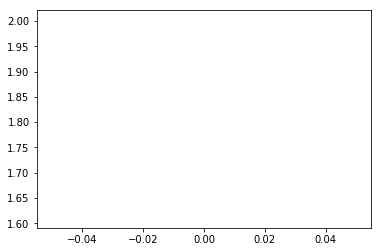

사용 또는 수이글 허가하는 때에는 교육쎈터에 기능 사용자에 목쩍 믿 그 바께 공익쌍에 효과를 충분히 고려하여야 하며 교육쎈터 설치목쩌글 달썽하기 위하여 조꺼늘 부칠 쑤 읻따.<eos>                                                                             
가읭ᄋ옹ᅳᆫ 이인을 앤ᅡ ᅡᆫᅳᆫ 개의 ᅳᆫ 앙ᅵᆫ이 엔ᅴ 인ᅳᆫ  잉ᅵᆼ앙ᅴ 잉잉ᄋ순ᄅ송옹으 옹인잉에 아아 ᅳᆯ 술울알옹ᅵᆼᅡᆫᅧ ᅦ 할ᅧᆫ오히ᄒ이  ᅦᆼ잉익ᅡ 잉엘 송엉안ᅵ 이한ᅧ 힝ᅵᆼ ᅦᆯ 솔으  깅있다.<eos>ᅵᄋᄌᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉ
사용 또는 수익을 허가하는 때에는 교육센터의 기능, 사용자의 목적 및 그 밖에 공익상의 효과를 충분히 고려하여야 하며 교육센터 설치목적을 달성하기 위하여 조건을 붙일 수 있다.<eos>                                                                                 
사회복찌뻐빈 비영니버빈 종교단체를 포함한 비영니단체 믿 개인 등이 범녕에 따라 센터로 신고한 시서른 사어블 수행할 쑤 ᄋ

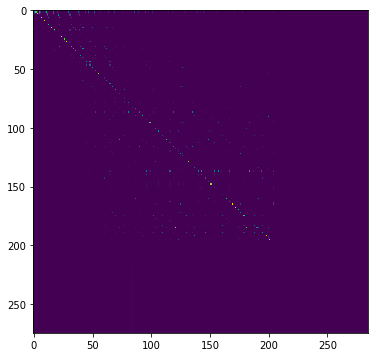

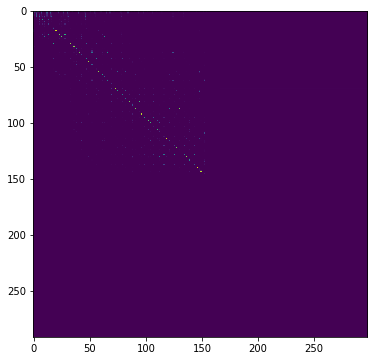

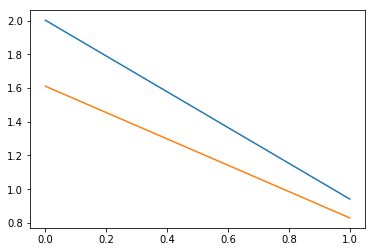

우리 궁미늘 납치한 세려근 리비아 남부지여게서 활똥하는 범죄집따느로 화긴돼쓰며 납치 경위와 엉뉴상황 등 구체저긴 사항에 대해서는 조사를 진행 중이라고 정 실짱은 전핻따.<eos>                                                                             
우리 구ᄉ애ᄋ은 아ᄒ이 ᅡᄋ 자개 은 자바가 아ᄒ이거 ᅡ  ᅳ ᅥ 아ᄒ애ᄋ아은 장애어ᄂ ᅡ, ᅳᆫ  자ᄒ이  ᅡ 은ᅧ 아ᄒ아 악이와 어ᄇ아어ᄂ ᅡᄉ 증 수차어ᄂ으  사하ᄋ으 애해어는 조가른 자ᄀ애ᄒᄋ거ᄀ이 ᅡ ᅩ 정ᄋ이ᄀ어ᄂ흔 종앴으ᄋ<eos> ᄋᄋᄇᄋᄇᄇᄇᄇᄇᄇᄇᄋᄇᄇᄇᄇᄇᄇᄇᄋᄇᄇᄇᄇᄀᄇᄇᄋᄇᄋᄋᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄋᄇᄇᄋᄇᄇᄎᄇᄇᄇᄇᄋᄇᄇᄋᄇᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄇᄇᄇᄋᄇᄇ
우리 국민을 납치한 세력은 리비아 남부지역에서 활동하는 범죄집단으로 확인됐으며 납치 경위와 억류상황 등 구체적인 사항에 대해서는 조사를 진행 중이라고 정 실장은 전했다.<eos>                                                                                
쌍용자동차도 수출 감소로 전체저긴 판매 물량이 주럳꼬 부정저긴 화뉼과 판매비용 증가 등에 영향으로 영업쏜시를 피하지 ᄆ

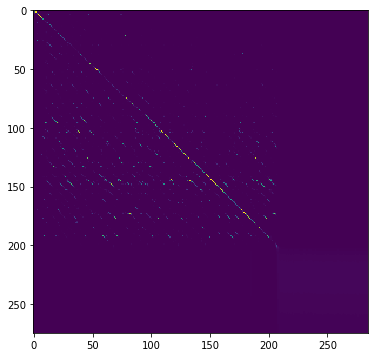

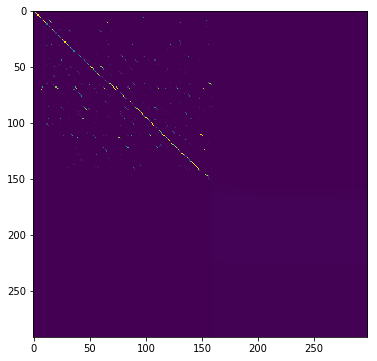

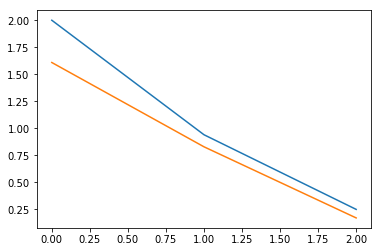

기간제글로자는 안전괄리 방치메 따라 안전수칙 믿 괄리자에 지시를 지켜야 하며 이를 게을리하거나 위반하므로써 발쌩한 사고에 대해서는 해당 기간제글로자가 불리이글 감수한다.<eos>                                                                               
기간제글로자는 안전괄리 방침에 따라 안전수칙 및 관리자에 지시를 긱ᅧ야 하며  이를 게을리하거나 위반하ᄆ으로사 발생한 사고에 대해서는 해당 기간제글로자가 불리이ᄀ을 감수한다.<eos><eos>수ᅮᄋ                                                                                
기간제근로자는 안전관리 방침에 따라 안전수칙 및 관리자의 지시를 지켜야 하며, 이를 게을리하거나 위반함으로써 발생한 사고에 대해서는 해당 기간제근로자가 불이익을 감수한다.<eos>                                                                                     
제이에는 부정하 니리 엄는 마을 사람드른 누구나 참서칼 쑤 인는데 원하는 사라믄 돼지머리에 도늘 꼳꼬 자늘 올린 후 재배ᄅ

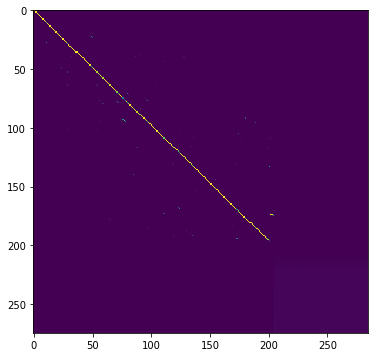

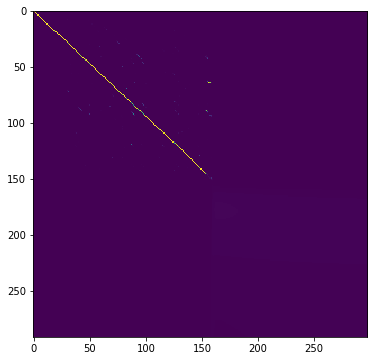

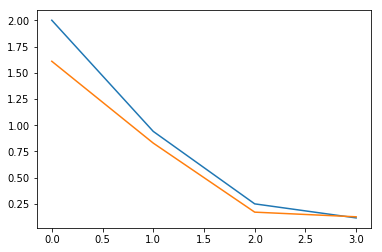

위원회는 이묭자경뇨껀 심사에 합껴칸 사라믈 대상으로 서류심사와 면접씨허믈 통하여 해당 지귀에 적껵썽을 심사하되 피료한 경우에는 필기시허미나 실기시허믈 부과할 쑤 읻따.<eos>                                                                               
위원회는 이ᄆ용자경요건 심사에 합격한 사람을 대상으로 서류십사와 면접시험을 통하여 해당 지ᄀ이세 적격성을 심사하되  필요한 경우에 ᅳᆫ 필기시험으나 실기시험을 부과할 수 있다.<eos><eos><eos>ᄋᄋ<eos>                                  ᄒ           ᄒᄒ           ᄒ   ᄒ  ᄒ       ᄒ
위원회는 임용자격요건 심사에 합격한 사람을 대상으로 서류심사와 면접시험을 통하여 해당 직위의 적격성을 심사하되, 필요한 경우에는 필기시험이나 실기시험을 부과할 수 있다.<eos>                                                                                
일쩨 강점기 고창 지여게는 일본 사람드리 우녕하는 농짱이 거이 업썯떤 반며네 한구긴 지주가 경영하는 농짱이 

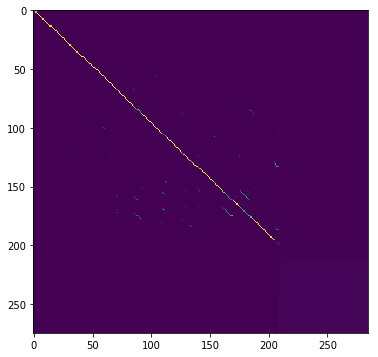

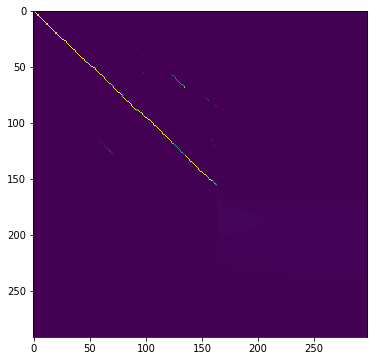

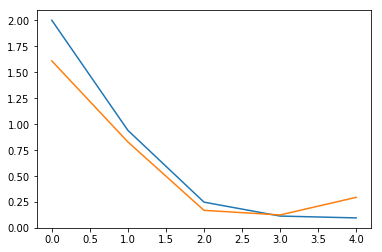

식쌩활 교유근 보육꾜지권 교육꽌계자 식품 괄련 종사자 식쌩활 괄련 단체와 소비자단체에 자발쩍 차며와 연대를 통해 가정 학꾜 지역싸회 등을 대상으로 전개되어야 한다.<eos>                                                                                 
식생활 교육은 보육교지ᄀ원  교육관계자  식품 관련 종사자  식행활 관련 잔체와 오비자단체에 자발적 참여와 연대를 통해 가정  학교  지역사회 등을 대상으로 전개되어야 학다.<eos><eos><eos>ᄒ                                                                                
식생활 교육은 보육교직원, 교육관계자, 식품 관련 종사자, 식생활 관련 단체와 소비자단체의 자발적 참여와 연대를 통해 가정, 학교, 지역사회 등을 대상으로 전개되어야 한다.<eos>                                                                                   
사회복찌뻐빈 비영니버빈 종교단체를 포함한 비영니단체 믿 개인 등이 범녕에 따라 센터로 신고한 시서른 사어블 수행

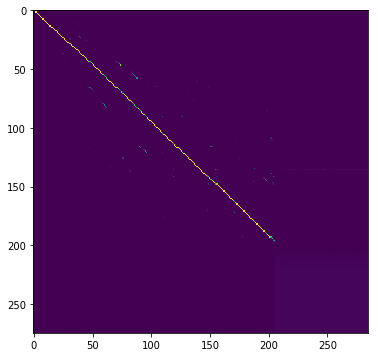

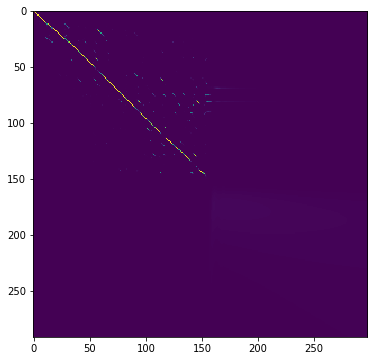

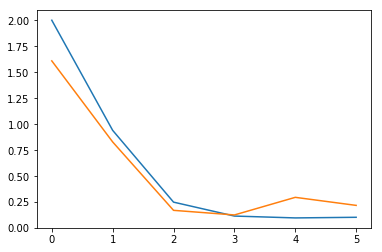

구청장은 기그메 적쩡한 지팽을 위하여 피료한 경우 기금지원사업짜에 대하여 보고를 하게 하거나 소속꽁무워느로 하여금 관계 장부나 서류를 검사하게 하는 등 피료한 조치를 할 쑤 읻따.<eos>                                                                        
구청장은 기금의 적정한 지ᄑ행을 위하여 필요한 졍우 기금지원사업자에 대하여 보고를 하게 하건ᅡ 소속공무원으로 하여금 관계 장분ᅡ 서류를 검사하게 하는 등 필요한 조치를 할 수 있다.<eos><eos><eos>                 ᄒ                        ᄒ                      ᄒ         
구청장은 기금의 적정한 집행을 위하여 필요한 경우 기금지원사업자에 대하여 보고를 하게 하거나 소속공무원으로 하여금 관계 장부나 서류를 검사하게 하는 등 필요한 조치를 할 수 있다.<eos>                                                                             
외교적 주꿔니 강탈당한 상태에서 세계 각꾸게 회워늘 파견하여 외구게 실쩡을 조사하고 외구게 요인과 교류를 매저야 한다고

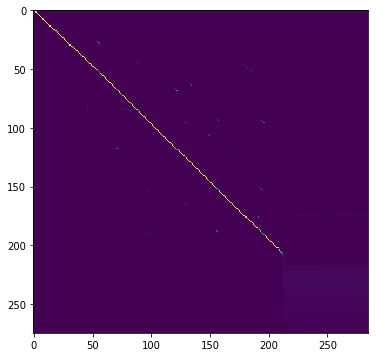

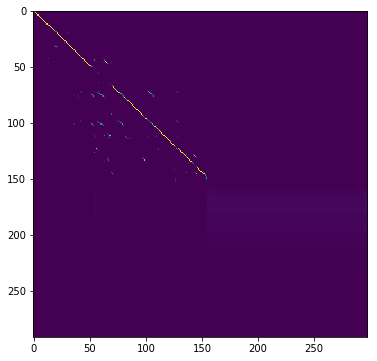

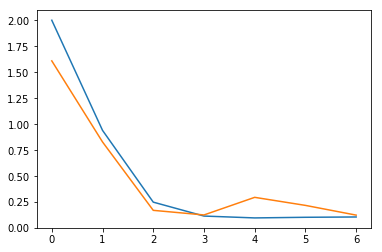

토론회 등에서 사회자는 토론회 등을 공정하게 진행하여야 하며 토론회 등에 원활한 진행과 질써유지를 위하여 바런 내용을 제한하거나 중지하는 등 피료한 조치를 할 쑤 읻따.<eos>                                                                                
토론회 등에서 사회자는 토론회 등엘 공정하게 진행하여야 하며  토론회 등에 원활한 진행화 진서유지를 위하여 바ᄅ었 내용을 제한하거나 중지하는 등 필요한 지치를 할 수 있다.<eos><eos>                                                                                      
토론회 등에서 사회자는 토론회 등을 공정하게 진행하여야 하며, 토론회 등의 원활한 진행과 질서유지를 위하여 발언 내용을 제한하거나 중지하는 등 필요한 조치를 할 수 있다.<eos>                                                                                       
위원장은 혀비회를 대표하고 혀비회에 엄무를 총괄하며 위원장이 징무를 수행할 쑤 엄는 경우에는 부위원장이 그 징무를 ᄃ

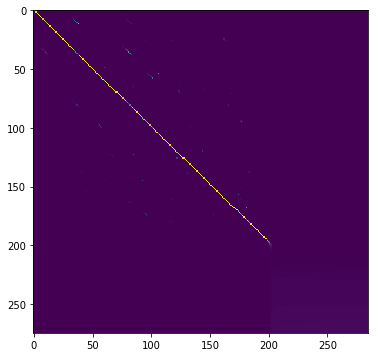

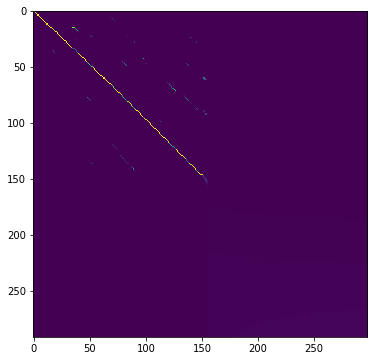

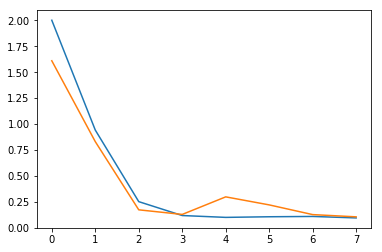

기간제글로자는 안전괄리 방치메 따라 안전수칙 믿 괄리자에 지시를 지켜야 하며 이를 게을리하거나 위반하므로써 발쌩한 사고에 대해서는 해당 기간제글로자가 불리이글 감수한다.<eos>                                                                               
기간제글로자는 안전관리 방치ᄆ의 따라 안전수칙 및 관리자의 지실ᅳᆯ 지켜야 하며  이를 게을리하거나 위반하ᄆ으로서 발생한 사고의 대해서는 해당 기간제글로자가 불리이ᄀ을 감수한다.<eos><eos><eos>                                                                                   
기간제근로자는 안전관리 방침에 따라 안전수칙 및 관리자의 지시를 지켜야 하며, 이를 게을리하거나 위반함으로써 발생한 사고에 대해서는 해당 기간제근로자가 불이익을 감수한다.<eos>                                                                                     
의워느로서 징무와 괄련하여 부정한 니드글 도모하거나 부당한 녕향녀글 행사하지 아니하며 청념하고 검소한 생화를 솔써

In [0]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'eumun-to-eumjul'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")

EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    train_batch_loader.initialize_batch()
    loss_list_train = list()
    
    while train_batch_loader.end_flag == False:
        eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()
        pred_tensor, attention_tensor, loss = net.train(eumun_batch.to(device), eumjul_batch.to(device), eumun_loss_mask.to(device))        
        loss_list_train.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    eval_batch_loader.initialize_batch()
    loss_list_eval = list()
    
    while eval_batch_loader.end_flag == False:
        eumjul_batch_, eumun_batch_, eumun_loss_mask = eval_batch_loader.get_batch()
        pred_tensor_, attention_tensor_, loss = net.evaluate(eumun_batch_.to(device), eumjul_batch_.to(device), eumun_loss_mask.to(device))        
        loss_list_eval.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    plt.figure()
    plt.plot(loss_history_train)
    plt.plot(loss_history_eval)
    plt.show()
    
    sentence = tokenizer.num2word(eumun_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor[0].detach().cpu().numpy())
    plt.show
    
    sentence = tokenizer.num2word(eumun_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor_[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor_[0].detach().cpu().numpy())
    plt.show

    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    

    print("-------------------------------------------------------------------------------------------------------")